# Applying OT-intNMF to PBMC

## Imports

In [6]:
# Biology
import scanpy as sc
import anndata as ad
import muon as mu

In [7]:
# Plotting
import matplotlib.pyplot as plt

In [8]:
# Our packages
from scmiot import models, pl, tl

In [9]:
# Maths
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import torch
from torch import optim
from umap import UMAP

In [10]:
# Progress bar
from tqdm.notebook import tqdm

## Load data

In [11]:
mdata = mu.read_h5mu('../datasets/PBMC_10k/preprocessed/pbmc10k.h5mu.gz')

In [12]:
rna = mdata.mod['rna']
atac = mdata.mod['atac']

## Varying genes

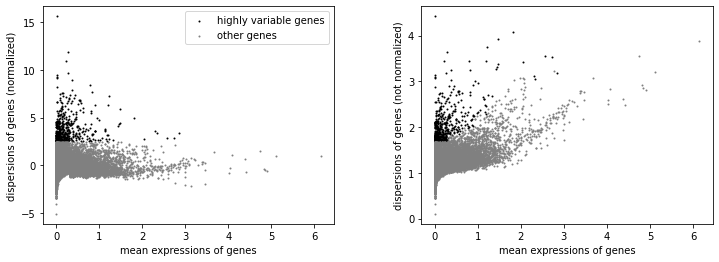

500

In [13]:
sc.pp.highly_variable_genes(rna, min_mean=0.2, max_mean=4, min_disp=0.5, n_top_genes=500)
sc.pl.highly_variable_genes(rna)
np.sum(rna.var.highly_variable)

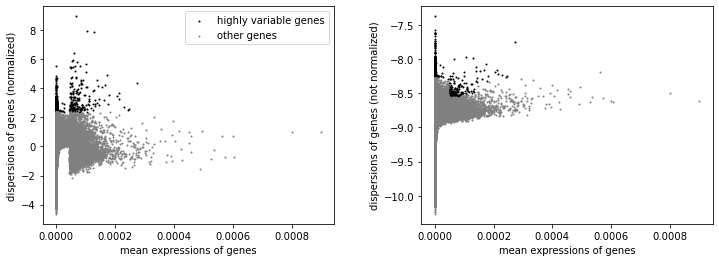

500

In [14]:
sc.pp.highly_variable_genes(atac, min_mean=3e-5, max_mean=5e-4, min_disp=0.7, n_top_genes=500)
sc.pl.highly_variable_genes(atac)
np.sum(atac.var.highly_variable)

## Subsample

In [15]:
rna = mdata.mod['rna']
atac = mdata.mod['atac']

In [16]:
sc.pp.subsample(rna, n_obs=800, random_state=0)
sc.pp.subsample(atac, n_obs=800, random_state=0)

In [17]:
# Create MuData object with rna and atac
mdata = mu.MuData({'rna': rna, 'atac': atac})

In [18]:
mu.pp.intersect_obs(mdata)
mdata

MuData object with n_obs × n_vars = 800 × 128106
  var:	'dispersions', 'dispersions_norm', 'highly_variable', 'mean_counts', 'means', 'n_cells_by_counts', 'pct_dropout_by_counts', 'total_counts'
  2 modalities
    rna:	800 x 22020
      obs:	'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg'
    atac:	800 x 106086
      obs:	'celltype', 'n_genes_by_counts', 'total_counts', 'n_counts'
      var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'atac', 'hvg'

## OT-intNMF

### Train model

In [60]:
from importlib import reload

In [61]:
reload(models)

<module 'scmiot.models' from '/users/csb/huizing/anaconda3/lib/python3.8/site-packages/scmiot/models.py'>

In [107]:
# hyperparameters
eps = .1
latent_dim = 20
rho_h = 5e-2
rho_w = 5e-2

In [108]:
nmf = models.OTintNMF(latent_dim=latent_dim, rho_h=rho_h, rho_w=rho_w, eps=eps, cost='correlation')

In [109]:
nmf.fit_transform(mdata, max_iter_inner=2_000, max_iter=100, device='cpu', dtype=torch.double, lr=5e-1, tol_inner=1e-3, tol_outer=1e-1, optim_name='lbfgs')

  5%|▌         | 10/200 [00:40<07:15,  2.29s/it, loss=-257.5072566032201]

### Convergence plots

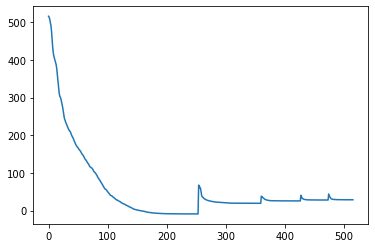

  5%|▌         | 10/200 [00:40<12:50,  4.06s/it, loss=-257.5072566032201]


In [110]:
plt.plot(nmf.losses_h)

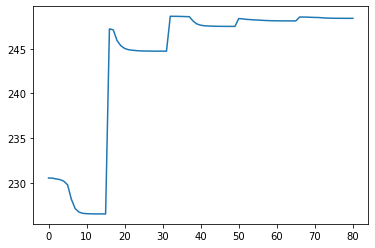

In [111]:
plt.plot(nmf.losses_w)

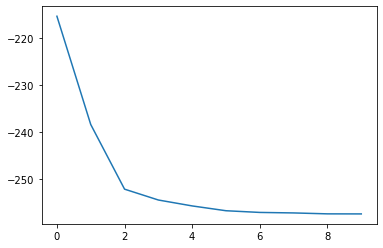

In [112]:
plt.plot(nmf.losses)

### Viz

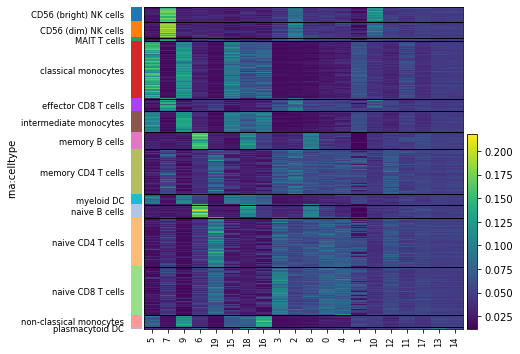

In [113]:
pl.heatmap(mdata, 'W_OT', 'rna:celltype')

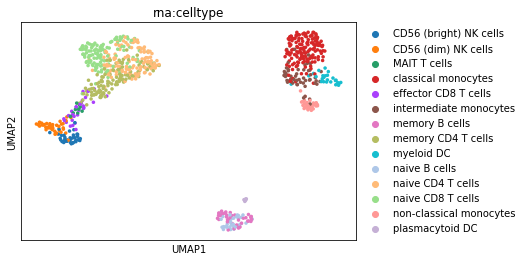

In [114]:
pl.umap(mdata, 'W_OT', 'rna:celltype')

## Variance explained

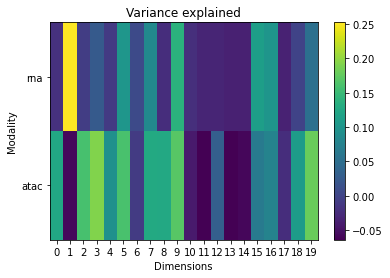

In [115]:
tl.variance_explained(mdata);